In [16]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
import traceback # For error handling
import qiskit
import inspect
import tweedledum as td

from tweedledum.bool_function_compiler import BoolFunction
from tweedledum.synthesis import xag_synth, xag_cleanup, pkrm_synth
from tweedledum.bool_function_compiler import BoolFunction
from tweedledum.classical import optimize
from tweedledum.passes import parity_decomp, linear_resynth
from tweedledum.bool_function_compiler.meta_inliner import transform_function

from clique_counter import parameterized_clique_counter_batcher, BoolFunctionTester

import logging
logging.disable()

# --- Factory Function ---
def create_specialized_bool_function(parameterized_func, **kwargs) -> BoolFunctionTester:
    """
    Specializes a parameterized function and returns a BoolFunction object.
    """
    # 1. Analyze signature (could be cached)
    signature = inspect.signature(parameterized_func)
    if not hasattr(parameterized_func, '_quantum_params'):
         raise ValueError("Function must be decorated with @circuit_input")
        
    # 2. Specialize function
    print("Specializing function...")
    specialized_src, specialized_func_obj = parameterized_func(**kwargs)
    print("Specialization complete.")

    # 4. Create BoolFunction
    print("Creating BoolFunction...")
    bool_func = BoolFunctionTester(specialized_src)
    print("BoolFunction created.")
    return bool_func

# --- Synthesis Function ---
def synthesize_oracle_xag(bool_function: BoolFunctionTester, oracle_qubit: int, oracle_type='phase', optimize_xag=True) -> qiskit.QuantumCircuit:
    """
    Synthesizes a Qiskit oracle from a concrete BoolFunction object.
    """
    print(f"Synthesizing {oracle_type} oracle from BoolFunction...")
    config = {}
    td_circuit = None

    timings = dict()

    # Optional: Optimize XAG before synthesis
    if optimize_xag:
         print("Optimizing XAG...")
         xag = bool_function.logic_network()
         xag_optimize_start_time = time.time()
         xag = xag_cleanup(xag)
         optimize(xag)
         timings['xag optimize'] = time.time() - xag_optimize_start_time

         print("Re-synthesizing from optimized XAG...")

    xag_synth_start_time = time.time()
    td_circuit = xag_synth(xag)
    timings['xag synthesis'] = time.time() - xag_synth_start_time

    print("Applying Tweedledum passes...")
    parity_decomp_start_time = time.time()
    td_circuit = parity_decomp(td_circuit)
    timings['parity decomp'] = time.time() - parity_decomp_start_time
    
    linear_resynth_start_time = time.time()
    td_circuit = linear_resynth(td_circuit)
    timings['linear resynth'] = time.time() - linear_resynth_start_time
    print(f"Tweedledum circuit optimized")

    print("Converting to Qiskit circuit...")
    qiskit_oracle = td.converters.to_qiskit(td_circuit, circuit_type="gatelist")
    print("Conversion complete.")

    if oracle_type == 'phase':
        oracle = qiskit.QuantumCircuit(qiskit_oracle.num_qubits)
        oracle.x(oracle_qubit)
        oracle.h(oracle_qubit)
        oracle.compose(qiskit_oracle, inplace=True)
        oracle.h(oracle_qubit)
        oracle.x(oracle_qubit)
        return oracle, timings
    elif oracle_type == 'bitflip':
        return qiskit_oracle, timings
    else:
        raise ValueError(f"Unknown oracle_type: {oracle_type}")


# --- Synthesis Function Using Truth Table ---
def synthesize_oracle_tt(bool_function: BoolFunctionTester, oracle_qubit: int, oracle_type='phase') -> qiskit.QuantumCircuit:
    """
    Synthesizes a Qiskit oracle from a concrete BoolFunction object.
    """
    print(f"Synthesizing {oracle_type} oracle from BoolFunction...")
    config = {}
    td_circuit = None

    timings = dict()

    
    tt_synth_start_time = time.time()
    bool_function.simulate_all()
    print(type(bool_function._truth_table[0]))
    td_circuit = pkrm_synth(bool_function._truth_table[0])
    timings['tt synthesis'] = time.time() - tt_synth_start_time

    print("Applying Tweedledum passes...")
    parity_decomp_start_time = time.time()
    td_circuit = parity_decomp(td_circuit)
    timings['parity decomp'] = time.time() - parity_decomp_start_time
    
    linear_resynth_start_time = time.time()
    td_circuit = linear_resynth(td_circuit)
    timings['linear resynth'] = time.time() - linear_resynth_start_time
    print(f"Tweedledum circuit optimized")

    print("Converting to Qiskit circuit...")
    qiskit_oracle = td.converters.to_qiskit(td_circuit, circuit_type="gatelist")
    print("Conversion complete.")

    if oracle_type == 'phase':
        oracle = qiskit.QuantumCircuit(qiskit_oracle.num_qubits)
        oracle.x(oracle_qubit)
        oracle.h(oracle_qubit)
        oracle.compose(qiskit_oracle, inplace=True)
        oracle.h(oracle_qubit)
        oracle.x(oracle_qubit)
        return oracle, timings
    elif oracle_type == 'bitflip':
        return qiskit_oracle, timings
    else:
        raise ValueError(f"Unknown oracle_type: {oracle_type}")

# --- Helper Functions ---)
    timings['tt synthesis'] = time.time() - tt_synth_start_time

def graph_to_binary_edge_list(g):
    """Converts NetworkX graph to the flat edge list format."""
    n = g.number_of_nodes()
    nodes = list(g.nodes()) # Ensure consistent node ordering if not 0..n-1
    node_map = {node: i for i, node in enumerate(nodes)}
    adj = nx.to_numpy_array(g, nodelist=nodes)
    edges = []
    for i in range(n):
        for j in range(n):
             # Your original code implies i,j are the indices passed to the func
             # which usually match the BitVec indices 0..n-1
             # Let's assume the function expects indices 0..n-1
            edges.append(int(adj[i, j]))
            # Original code had int(G.has_edge(i,j)) which might fail if nodes != range(n)
            # edges.append(int(g.has_edge(i, j)))
    return edges

def count_cliques(graph, k):
    from networkx.algorithms import enumerate_all_cliques
    """Classically counts cliques of size <= k."""
    cliques = list(enumerate_all_cliques(graph))
    count = len([node_list for node_list in cliques if len(node_list) >= k])
    return count



In [10]:
# === Main Evaluation Routine ===
from clique_counter import parameterized_clique_counter
from qiskit_aer import AerSimulator

from typing import Callable

def evaluate_compiler_performance(
    synth_func: Callable,
    n_range=range(3, 11),
    p_values=[0.2, 0.5, 0.8],
    k_func=lambda n: math.ceil(n / 2), # Function to determine k from N
    num_runs=1, # Number of random graphs per (N, p) pair
    visualize=False,
    ):
    """
    Runs the compiler pipeline on random graphs and collects statistics.

    Args:
        n_range: Range of graph sizes (N) to test.
        p_values: List of edge probabilities (p) for G(N,p) graphs.
        k_func: A function that takes N and returns the target clique size k.
        num_runs: How many random graphs to generate for each (N, p).

    Returns:
        pandas.DataFrame containing the collected statistics.
    """
    results_list = []
    run_id_counter = 0

    # --- Outer loops for parameters ---
    for n in n_range:
        target_k = k_func(n)
        print(f"\n--- Processing N = {n}, Target k >= {target_k} ---")

        for p in p_values:
            print(f"  Processing p = {p:.2f}")

            for run in range(num_runs):
                run_id_counter += 1
                print(f"    Run {run + 1}/{num_runs}")
                start_time = time.time()
                run_data = {'run_id': run_id_counter, 'N': n, 'p': p, 'k': target_k}

                # --- 1. Generate Reproducible Random Graph ---
                seed = hash((n, p, run_id_counter)) # Simple reproducible seed
                G = nx.gnp_random_graph(n, p, seed=seed)
                edges = graph_to_binary_edge_list(G)
                run_data['num_edges'] = G.number_of_edges()
                run_data['edge_list'] = edges

                if(visualize):
                    plt.figure(run_id_counter)
                    #plt.title(f"N={n}, k={target_k}")
                    plt.show(block=False)

                # --- 2. (Optional but Recommended) Count Solutions Classically ---
                try:
                    num_solutions_m = count_cliques(G, target_k)
                    run_data['num_solutions_m'] = num_solutions_m
                    print(f"      Graph generated. Found {num_solutions_m} cliques >= size {target_k}.")
                    if num_solutions_m == 0 and n < 15: # Avoid for large N where it's expected
                         print("      Warning: No solutions found for this graph instance.")
                except Exception as e:
                    print(f"      Error counting cliques: {e}")
                    run_data['num_solutions_m'] = -1 # Indicate error

                # --- 3. Run Your Compiler Pipeline ---
                oracle = None
                compiler_successful = False
                error_message = "None"

                try:
                    # a) Compile Python -> Specialized Source
                    print("      Compiling Python function...")
                    classical_inputs = {'n': n, 'k': target_k, 'edges': edges}

                    # use classical inputs to generate a boolean function 
                    bool_function = create_specialized_bool_function(parameterized_clique_counter_batcher, **classical_inputs)
                    
                    # from the boolean function synthesize an oracle
                    oracle, pipeline_timings = synth_func(bool_function, n)

                    compiler_successful = True
                    print("      Pipeline successful.")

                except Exception as e:
                    print(f"      ERROR during compiler pipeline: {e}")
                    print(traceback.format_exc()) # Uncomment for full traceback
                    error_message = str(e)
                    compiler_successful = False

                # --- 4. Collect Statistics ---
                run_data['compiler_success'] = compiler_successful
                run_data['error_message'] = error_message

                if compiler_successful and oracle is not None:                
                    end_time = time.time()
                    run_data['compilation_time'] = end_time - start_time
                    print(f"      Time taken: {run_data['compilation_time']:.2f}s")
                    
                    if(visualize):
                        print(oracle.draw())
                   
                    # Add detailed timings
                    for key in pipeline_timings:
                        col_name = f"time_{key.replace(' ', '_')}" # e.g., time_xag_optimize
                        run_data[col_name] = pipeline_timings.get(key, np.nan if compiler_successful else -1) # Use NaN for missing timings if successful, -1 if failed
                
                    run_data['oracle_num_qubits'] = oracle.num_qubits
                    try:
                        # Transpile slightly to get depth/counts in a reasonable basis
                        # Use level 0 just for basis translation if needed
                        print("      Transpiling oracle for stats...")
                        sim_temp = AerSimulator() # For basis info
                        oracle_transpiled = qiskit.transpile(oracle, backend=sim_temp, optimization_level=0)

                        run_data['oracle_depth'] = oracle_transpiled.depth()
                        run_data['oracle_size'] = oracle_transpiled.size() # Total ops
                        ops_counts = oracle_transpiled.count_ops()
                        run_data['oracle_cx_count'] = ops_counts.get('cx', 0)
                        run_data['oracle_1q_count'] = sum(count for op, count in ops_counts.items() if op != 'cx' and op != 'barrier' and op!= 'measure')
                        # Add more specific gates if needed
                        # run_data['oracle_h_count'] = ops_counts.get('h', 0)
                        # run_data['oracle_rx_count'] = ops_counts.get('rx', 0)
                    except Exception as e:
                         print(f"      ERROR during oracle analysis: {e}")
                         run_data['oracle_depth'] = -1
                         run_data['oracle_size'] = -1
                         run_data['oracle_cx_count'] = -1
                         run_data['oracle_1q_count'] = -1

                else:
                    # Assign default error values if compilation failed
                    run_data['oracle_num_qubits'] = -1
                    run_data['oracle_depth'] = -1
                    run_data['oracle_size'] = -1
                    run_data['oracle_cx_count'] = -1
                    run_data['oracle_1q_count'] = -1
                    run_data['compilation_time'] = -1



                # --- 5. Store Data ---
                results_list.append(run_data)

    # --- Convert list of dictionaries to DataFrame ---
    df_results = pd.DataFrame(results_list)
    return df_results

In [3]:
# === Example Usage ===

# Define N range, p values, and k function
n_values = range(3, 8) # Smaller range for quicker test
# p_values = [0.2, 0.5, 0.8]
p_values = [0.1] # Single p for quicker test
k_func = lambda n: math.floor(n / 2) # k = N/2 rounded down
#k_func = lambda n: 3 if n >= 3 else n # Fix k=3 for N>=3 for testing comparison
#k_func = lambda _: 2


# Run the evaluation
compiler_results_df = evaluate_compiler_performance(
    synth_func=synthesize_oracle_xag,
    n_range=n_values,
    p_values=p_values,
    k_func=k_func,
    num_runs=10 # Run twice per setting for averaging potential
)

# Display the results
print("\n\n=== Compiler Performance Results ===")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(compiler_results_df)


--- Processing N = 3, Target k >= 1 ---
  Processing p = 0.10
    Run 1/10
      Graph generated. Found 3 cliques >= size 1.
      Compiling Python function...
Specializing function...
Specialization complete.
Creating BoolFunction...
BoolFunction created.
Synthesizing phase oracle from BoolFunction...
Optimizing XAG...
Re-synthesizing from optimized XAG...
Applying Tweedledum passes...
Tweedledum circuit optimized
Converting to Qiskit circuit...
Conversion complete.
      Pipeline successful.
      Time taken: 0.01s
      Transpiling oracle for stats...
    Run 2/10
      Graph generated. Found 4 cliques >= size 1.
      Compiling Python function...
Specializing function...
Specialization complete.
Creating BoolFunction...
BoolFunction created.
Synthesizing phase oracle from BoolFunction...
Optimizing XAG...
Re-synthesizing from optimized XAG...
Applying Tweedledum passes...
Tweedledum circuit optimized
Converting to Qiskit circuit...
Conversion complete.
      Pipeline successful.
 

In [17]:
# Run the evaluation
tt_compiler_results_df = evaluate_compiler_performance(
    synth_func=synthesize_oracle_tt,
    n_range=n_values,
    p_values=p_values,
    k_func=k_func,
    num_runs=10 # Run twice per setting for averaging potential
)

# Display the results
print("\n\n=== Compiler Performance Results ===")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(tt_compiler_results_df)


--- Processing N = 3, Target k >= 1 ---
  Processing p = 0.10
    Run 1/10
      Graph generated. Found 3 cliques >= size 1.
      Compiling Python function...
Specializing function...
Specialization complete.
Creating BoolFunction...
BoolFunction created.
Synthesizing phase oracle from BoolFunction...
<class 'tweedledum._tweedledum.classical.TruthTable'>
Applying Tweedledum passes...
Tweedledum circuit optimized
Converting to Qiskit circuit...
Conversion complete.
      Pipeline successful.
      Time taken: 0.00s
      Transpiling oracle for stats...
    Run 2/10
      Graph generated. Found 4 cliques >= size 1.
      Compiling Python function...
Specializing function...
Specialization complete.
Creating BoolFunction...
BoolFunction created.
Synthesizing phase oracle from BoolFunction...
<class 'tweedledum._tweedledum.classical.TruthTable'>
Applying Tweedledum passes...
Tweedledum circuit optimized
Converting to Qiskit circuit...
Conversion complete.
      Pipeline successful.
     

In [23]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt # For drawing the graph
import math # If needed for k_func analysis later

# Assume compiler_results_df is your DataFrame loaded with results

def analyze_compiler_run(df: pd.DataFrame, synth_func: Callable, run_id_to_analyze: int, generate_oracle=False):
    """
    Selects a specific run from the results DataFrame, prints its details,
    and visualizes the corresponding graph.

    Args:
        df: The Pandas DataFrame containing the compiler evaluation results.
        run_id_to_analyze: The 'run_id' of the row to inspect.
    """
    print(f"\n--- Analyzing Run ID: {run_id_to_analyze} ---")

    # --- 1. Select the Row ---
    try:
        # Use boolean indexing to find the row(s) matching the run_id
        # .iloc[0] assumes run_id is unique and selects the first match as a Series
        row = df[df['run_id'] == run_id_to_analyze].iloc[0]
    except IndexError:
        print(f"Error: Run ID {run_id_to_analyze} not found in the DataFrame.")
        return
    except Exception as e:
        print(f"Error selecting row: {e}")
        return

    # --- 2. Extract Parameters and Results ---
    print("\nParameters:")
    n = int(row['N']) # Ensure integer type
    p = row['p']
    k = int(row['k']) # Ensure integer type
    num_edges = int(row['num_edges'])
    edge_list = row['edge_list'] # This is likely a list or string representation
    num_solutions_m = int(row['num_solutions_m'])
    compiler_success = row['compiler_success']
    error_message = row['error_message']
    compilation_time = row['compilation_time']

    print(f"  N (Vertices): {n}")
    print(f"  p (Edge Prob): {p}")
    print(f"  k (Min Clique): {k}")
    print(f"  Graph Edges Count: {num_edges}")
    print(f"  Edge List: {edge_list}")
    print(f"  Calculated Solutions (m): {num_solutions_m}")
    # print(f"  Edge List: {edge_list}") # Can be very long

    print("\nCompiler Results:")
    print(f"  Success: {compiler_success}")
    if not compiler_success:
        print(f"  Error: {error_message}")
    print(f"  Compilation Time (s): {compilation_time:.4f}")

    if compiler_success:
        oracle_num_qubits = int(row['oracle_num_qubits'])
        oracle_depth = int(row['oracle_depth'])
        oracle_size = int(row['oracle_size'])
        oracle_cx_count = int(row['oracle_cx_count'])
        oracle_1q_count = int(row['oracle_1q_count'])

        print(f"  Oracle Qubits: {oracle_num_qubits}")
        print(f"  Oracle Depth: {oracle_depth}")
        print(f"  Oracle Size (Total Gates): {oracle_size}")
        print(f"  Oracle CX Count: {oracle_cx_count}")
        print(f"  Oracle 1-Qubit Gate Count: {oracle_1q_count}")
        if oracle_num_qubits != -1:
             num_ancilla = oracle_num_qubits - n
             print(f"  Implied Ancilla Qubits: {num_ancilla} (Total - N)")
        else:
             print(f"  Implied Ancilla Qubits: Unknown")

    # --- 3. Reconstruct and Visualize the Graph ---
    print("\nGraph Structure:")
    try:
        # Ensure edge_list is a list of numbers if it's stored as a string
        if isinstance(edge_list, str):
            import ast as safe_ast
            edge_list = safe_ast.literal_eval(edge_list)

        if not isinstance(edge_list, list):
             raise TypeError(f"edge_list is not a list, but {type(edge_list)}")

        # Reshape the flat list into an adjacency matrix
        adj_matrix = np.array(edge_list).reshape((n, n))

        # Create graph from adjacency matrix
        G = nx.from_numpy_array(adj_matrix)

        # Draw the graph
        plt.figure(figsize=(6, 4))
        nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
        plt.title(f"Graph for Run ID {run_id_to_analyze} (N={n}, p={p}, k={k})")
        plt.show()

    except Exception as e:
        print(f"Error reconstructing/drawing graph: {e}")
        print(f"  Edge list type: {type(edge_list)}")
        # print(f"  Edge list value: {edge_list}") # Careful, might be huge

    if generate_oracle: 
        try: 
            classical_inputs = {'n': n, 'k': k, 'edges': edge_list}

            # use classical inputs to generate a boolean function 
            bool_function = create_specialized_bool_function(parameterized_clique_counter, **classical_inputs)
                    
            # from the boolean function synthesize an oracle
            oracle, _ = synth_func(bool_function, n)
            print(oracle.draw())
        except Exception as e:
            print(f"Error reconstructing oracle: {e}")

    print(f"--- End Analysis for Run ID: {run_id_to_analyze} ---")





--- Analyzing Run ID: 30 ---

Parameters:
  N (Vertices): 5
  p (Edge Prob): 0.1
  k (Min Clique): 2
  Graph Edges Count: 1
  Edge List: [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  Calculated Solutions (m): 1

Compiler Results:
  Success: True
  Compilation Time (s): 0.0629
  Oracle Qubits: 20
  Oracle Depth: 129
  Oracle Size (Total Gates): 230
  Oracle CX Count: 96
  Oracle 1-Qubit Gate Count: 134
  Implied Ancilla Qubits: 15 (Total - N)

Graph Structure:


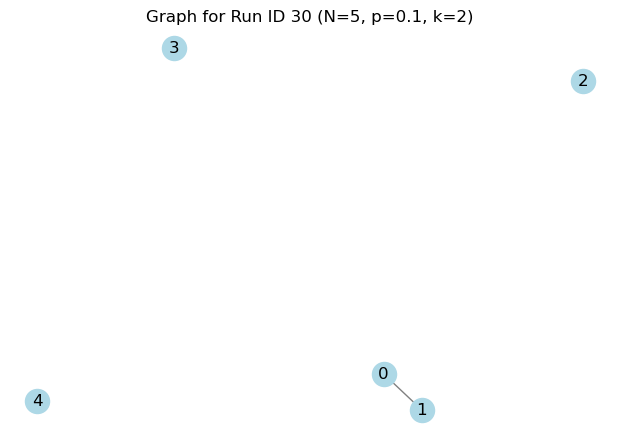

Specializing function...
Specialization complete.
Creating BoolFunction...
BoolFunction created.
Synthesizing phase oracle from BoolFunction...
Optimizing XAG...
Re-synthesizing from optimized XAG...
Applying Tweedledum passes...
Tweedledum circuit optimized
Converting to Qiskit circuit...
Conversion complete.
                                                                        »
q_0: ─────────■─────────────────────────────────────────────────────────»
              │                                                         »
q_1: ─────────┼────────■───────────────────────────■────────────────────»
              │        │                           │                    »
q_2: ─────────┼────────┼─────────────o─────────────┼─────────o──────────»
              │        │             │             │         │          »
q_3: ─────────┼────────o─────────────┼─────────────o─────────┼──────────»
              │        │             │             │         │          »
q_4: ─────────o───────

In [27]:
# === Example Usage ===

# Assume compiler_results_df is your DataFrame loaded from the previous step

# Choose a run ID you want to inspect (e.g., one with a qubit spike or error)
# Let's look at run_id 81 (the first one with N=7 and -1 results)
# or run_id 66 (N=6, large qubit count 29)
# or run_id 61 (N=6, non-zero edges but qubit count 12 - maybe simpler?)

run_id_to_inspect = 30 # Change this ID to explore different runs

analyze_compiler_run(compiler_results_df, synthesize_oracle_xag, run_id_to_inspect, generate_oracle=True)

# Example 2: Analyze a successful run with N=4
# run_id_to_inspect_success = 22 # Example run_id from your N=4 results
# analyze_compiler_run(compiler_results_df, run_id_to_inspect_success)


--- Analyzing Run ID: 30 ---

Parameters:
  N (Vertices): 5
  p (Edge Prob): 0.1
  k (Min Clique): 2
  Graph Edges Count: 1
  Edge List: [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  Calculated Solutions (m): 1

Compiler Results:
  Success: True
  Compilation Time (s): 0.0629
  Oracle Qubits: 20
  Oracle Depth: 129
  Oracle Size (Total Gates): 230
  Oracle CX Count: 96
  Oracle 1-Qubit Gate Count: 134
  Implied Ancilla Qubits: 15 (Total - N)

Graph Structure:


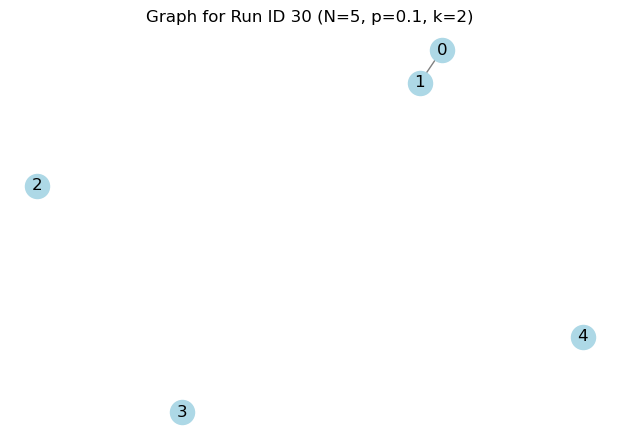

Specializing function...
Specialization complete.
Creating BoolFunction...
BoolFunction created.
Synthesizing phase oracle from BoolFunction...
<class 'tweedledum._tweedledum.classical.TruthTable'>
Applying Tweedledum passes...
Tweedledum circuit optimized
Converting to Qiskit circuit...
Conversion complete.
                              
q_0: ────────────■────────────
                 │            
q_1: ────────────■────────────
                 │            
q_2: ────────────o────────────
                 │            
q_3: ────────────o────────────
                 │            
q_4: ────────────o────────────
     ┌───┐┌───┐┌─┴─┐┌───┐┌───┐
q_5: ┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├
     └───┘└───┘└───┘└───┘└───┘
--- End Analysis for Run ID: 30 ---


In [28]:
analyze_compiler_run(compiler_results_df, synthesize_oracle_tt, run_id_to_inspect, generate_oracle=True)

In [30]:
 #--- Next Steps: Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

def visualize(df: pd.DataFrame):
    if not df.empty:
    	# Example Plot: Qubits vs N, colored by p
    	plt.figure(figsize=(10, 6))
    	sns.lineplot(data=df[df['compiler_success']],
    	          x='N', y='oracle_num_qubits', hue='p', marker='o', err_style="bars", errorbar="sd")
    	plt.title('Oracle Qubit Count vs Graph Size (N)')
    	plt.xlabel('Number of Vertices (N)')
    	plt.ylabel('Number of Qubits in Oracle')
    	plt.grid(True)
    	plt.show()
    	# Example Plot: Depth vs N, colored by p
    	plt.figure(figsize=(10, 6))
    	sns.lineplot(data=df[df['compiler_success']],
    	          x='N', y='oracle_depth', hue='p', marker='o', err_style="bars", errorbar="sd")
    	plt.title('Oracle Depth vs Graph Size (N)')
    	plt.xlabel('Number of Vertices (N)')
    	plt.ylabel('Oracle Circuit Depth')
    	plt.grid(True)
    	plt.show()
    	# Example Plot: CX Count vs N, colored by p
    	plt.figure(figsize=(10, 6))
    	sns.lineplot(data=df[df['compiler_success']],
    	          x='N', y='oracle_cx_count', hue='p', marker='o', err_style="bars", errorbar="sd")
    	plt.title('Oracle CNOT Count vs Graph Size (N)')
    	plt.xlabel('Number of Vertices (N)')
    	plt.ylabel('Number of CX gates in Oracle')
    	plt.grid(True)
    	plt.show()
    	# Example Plot: Compilation Time vs N, colored by p
    	plt.figure(figsize=(10, 6))
    	sns.lineplot(data=df[df['compiler_success']],
    	          x='N', y='compilation_time', hue='p', marker='o', err_style="bars", errorbar="sd")
    	plt.title('Compilation Time vs Graph Size (N)')
    	plt.xlabel('Number of Vertices (N)')
    	plt.ylabel('Time (s)')
    	plt.grid(True)
    	plt.show()

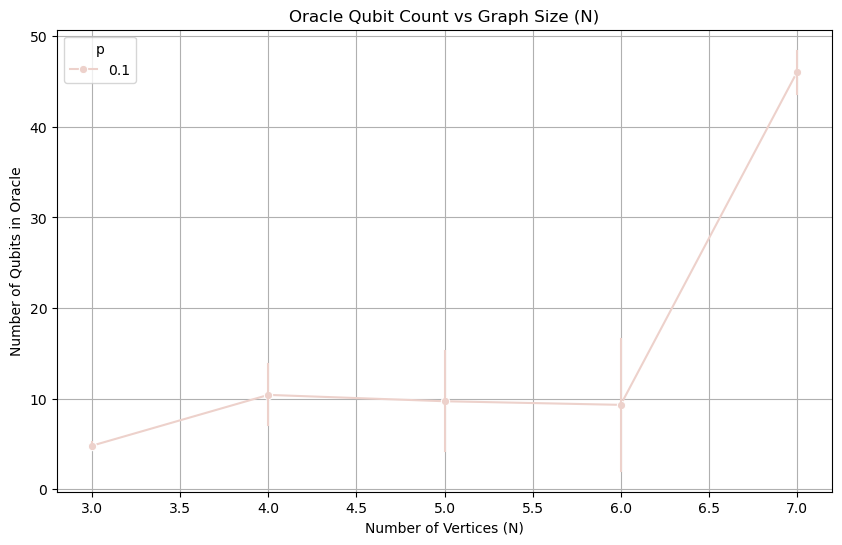

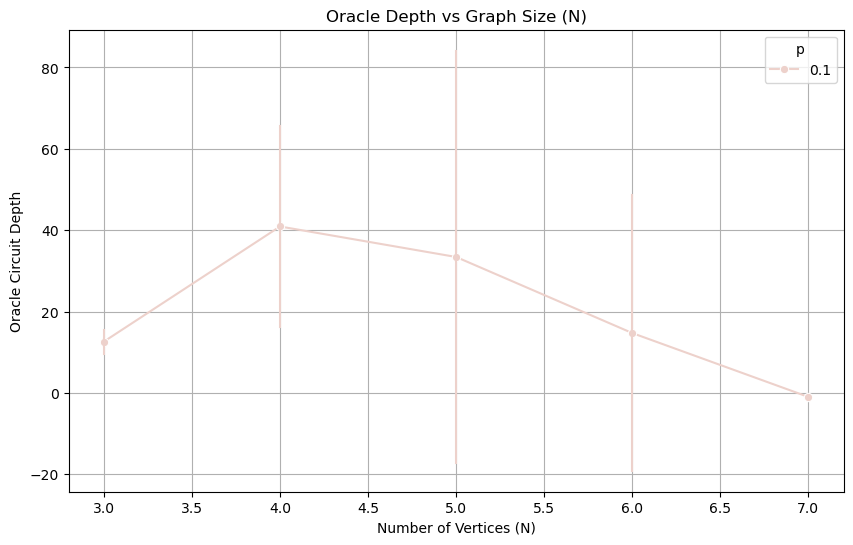

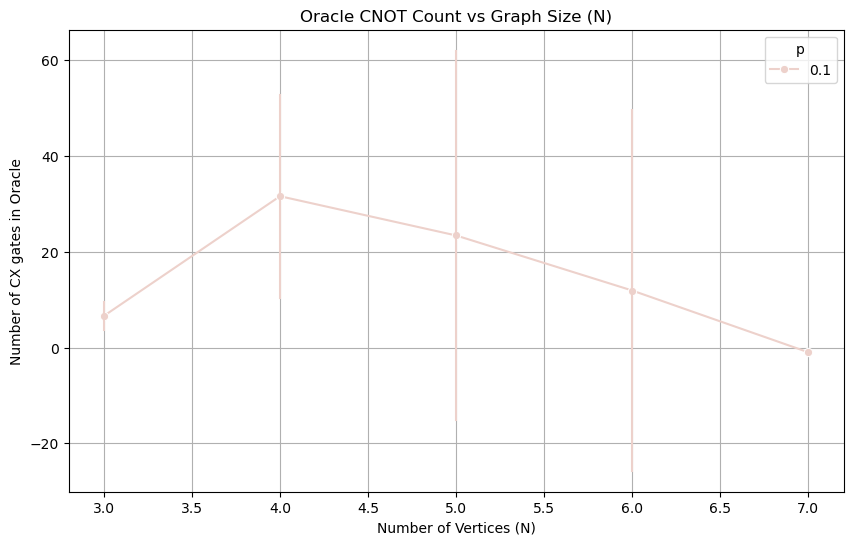

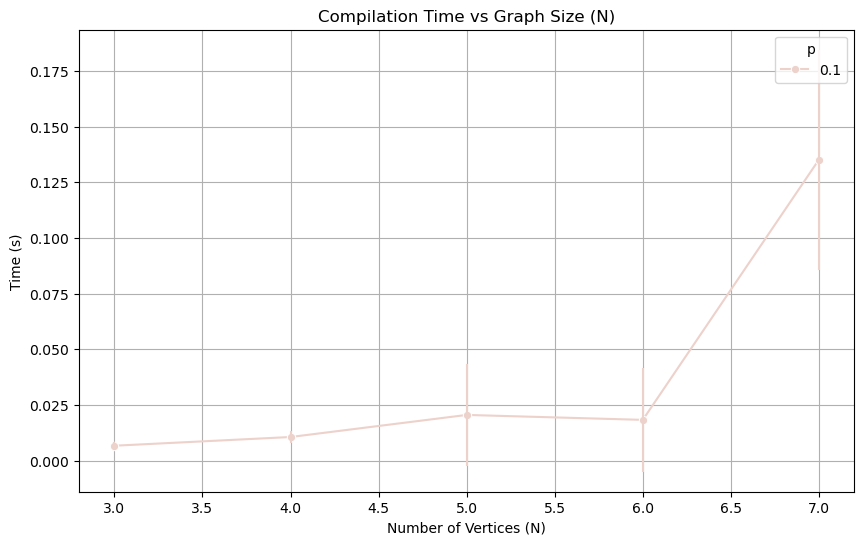

In [31]:
visualize(compiler_results_df)

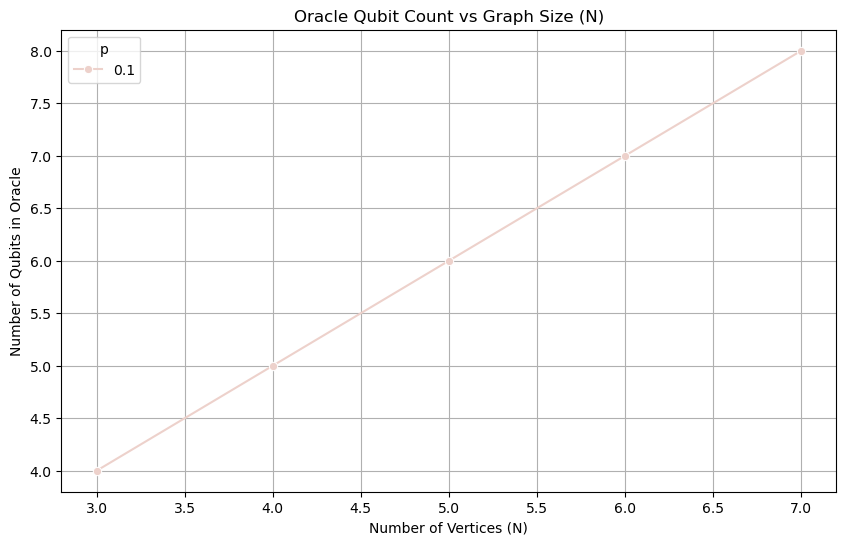

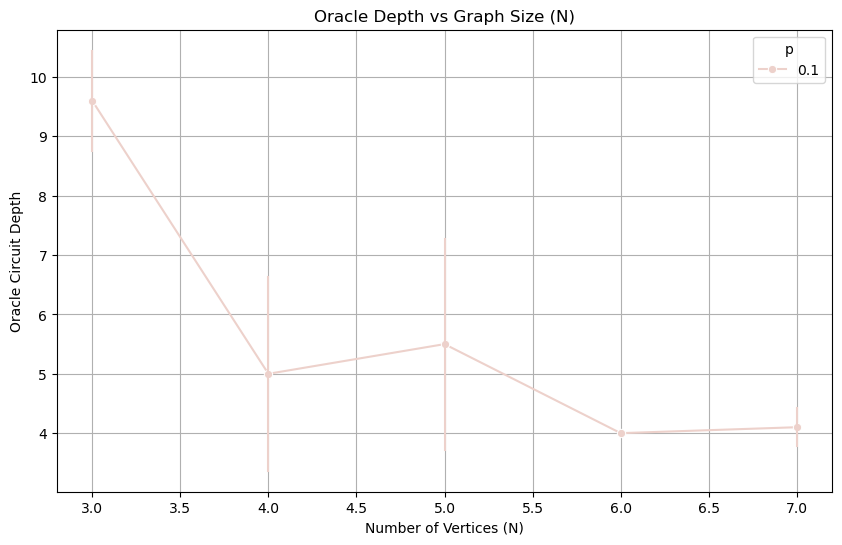

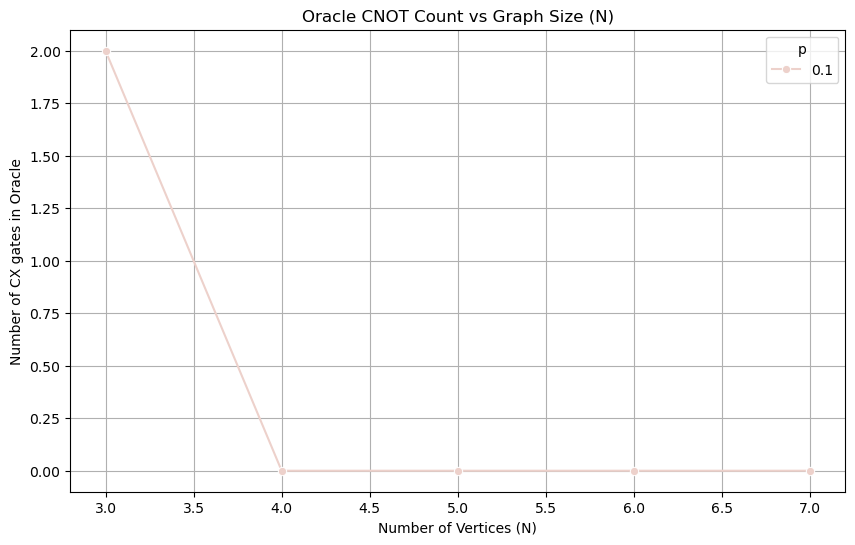

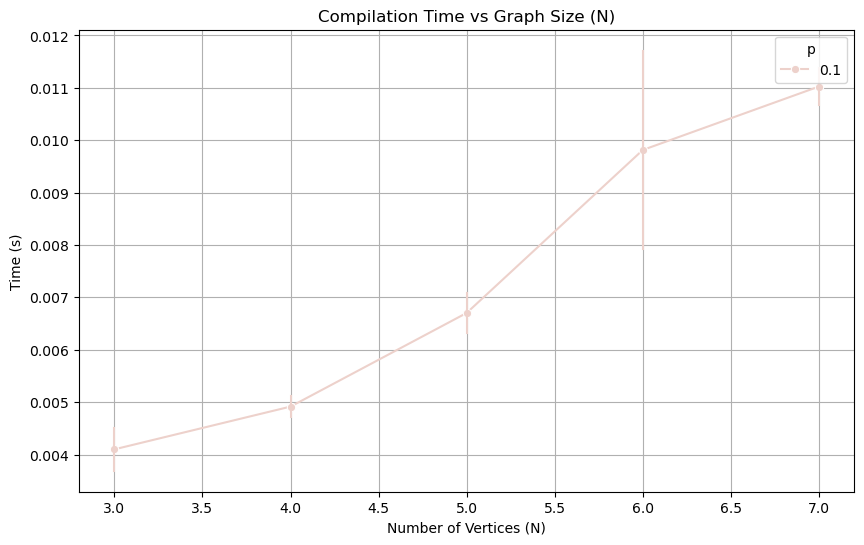

In [32]:
visualize(tt_compiler_results_df)